# **House Price Prediction using ML**

## **<span style="color:blue">Introduction</span>**

Predicting house prices is a crucial task that can benefit real estate professionals, buyers, and sellers by providing data-driven insights. These predictions help in making informed decisions regarding property investments, market evaluations, and pricing strategies.

The goal of this study is to accurately predict house prices using a variety of features from a given dataset.

In [178]:
import os
import re
import joblib
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown, display
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures

SEED = 42
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

## **<span style="color:blue">Explanatory Data Analysis</span>**

### Load data and quick look

In [179]:
df = pd.read_csv('house_data.csv')
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              3961 non-null   float64
 1   Avg. Area House Age           3959 non-null   float64
 2   Avg. Area Number of Rooms     4000 non-null   float64
 3   Avg. Area Number of Bedrooms  4000 non-null   float64
 4   Area Population               4000 non-null   float64
 5   Price                         4000 non-null   float64
 6   Address                       4000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 218.9+ KB


In [181]:
df.duplicated().sum()

0

The dataset loaded contains various features related to houses, such as the number of bedrooms, bathrooms, square footage, location, and other relevant attributes. The target variable is the **<span style="color:blue">price** of the house.

Here we can notice a first problem, the dataset contains some missing values. Let's now check the descriptive statistics of the dataset to understand the distribution of the features and identify any potential outliers.

In [182]:
df.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,3961.000000,3959.000000,4000.000000,4000.000000,4000.000000,4.000000e+03
mean,68544.054944,5.982490,7.118633,3.974775,36989.075072,1.235349e+06
std,10690.921040,0.989870,1.670684,1.231435,12099.449210,3.544019e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61471.412630,5.336266,6.314666,3.140000,29643.665020,9.997036e+05
50%,68638.107850,5.969801,7.009158,4.045000,36360.221275,1.237303e+06
75%,75782.335140,6.661217,7.690617,4.490000,43232.044225,1.469933e+06
max,107701.748400,9.519088,20.963376,6.500000,108490.548116,2.469066e+06


The average house price is approximately $1.23 million, with a significant range from about $16 K to $2.47 M. On average, houses have around 7 rooms and nearly 4 bedrooms, with house ages averaging about 6 years. Area income averages around $68 K, while the average population of the areas is approximately 37 K.

The data also shows some variation in these attributes, with standard deviations indicating moderate to high dispersion from the mean values.

### Data Visualization

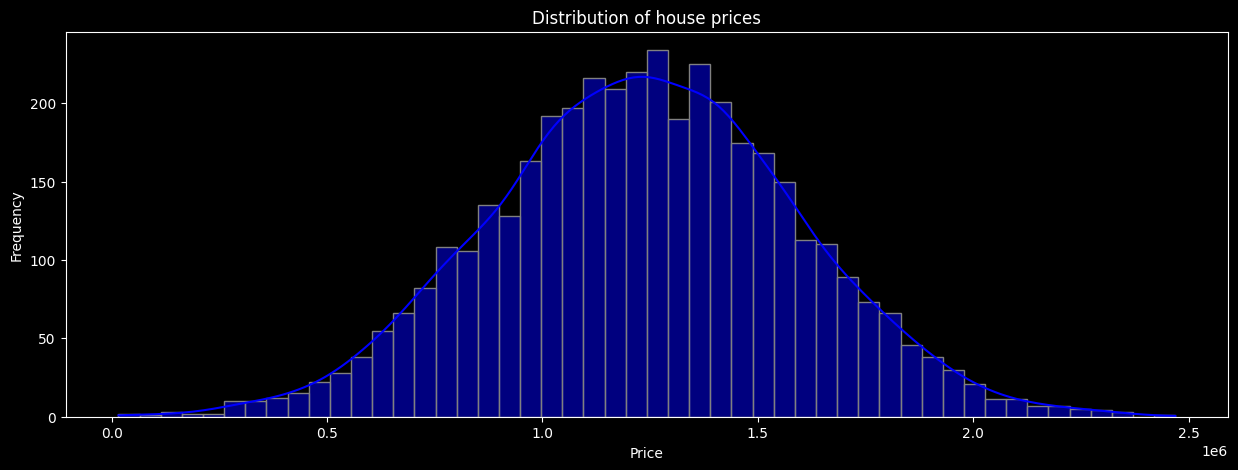

In [183]:
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))
sns.histplot(df['Price'], bins=50, kde=True, color='blue', edgecolor='gray')
plt.title('Distribution of house prices')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

Most properties are clustered around a central price range, suggesting a relatively balanced market with typical pricing near the average. The smooth curve overlay indicates that the data closely follows a normal distribution, with fewer homes priced at the extreme low or high ends. This visualization helps identify pricing trends and supports informed decision-making for buyers, sellers, and investors.

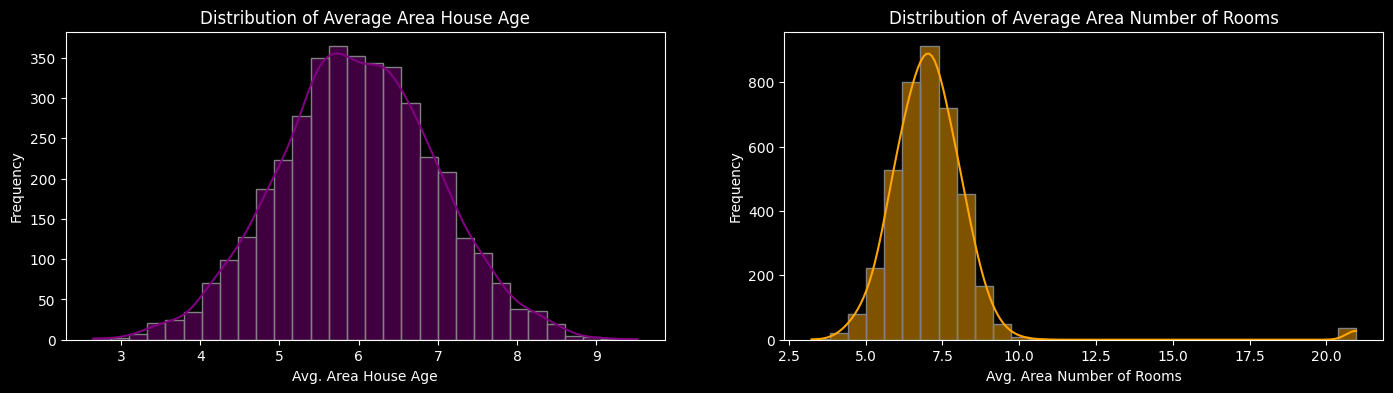

In [184]:
fig, ax = plt.subplots(1, 2, figsize=(17, 4))
sns.histplot(df['Avg. Area House Age'], bins=30, kde=True, color='purple', edgecolor='gray', ax=ax[0])
sns.histplot(df['Avg. Area Number of Rooms'], bins=30, kde=True, color='orange', edgecolor='gray', ax=ax[1])
ax[0].set_title('Distribution of Average Area House Age')
ax[0].set_ylabel('Frequency')
ax[1].set_title('Distribution of Average Area Number of Rooms')
ax[1].set_ylabel('Frequency')
plt.grid(False)
plt.show()

The two histograms provide insights into key housing features across different areas. The distribution of average house age appears roughly normal, with most homes being around 5 to 7 years old (avg=6 yrs), suggesting relatively recent development in these neighborhoods. In contrast, the distribution of average number of rooms is right-skewed, indicating that while most homes have around 6 rooms, there are a few areas with significantly larger properties. These patterns help characterize the housing stock and may reflect differences in urban planning, socioeconomic status, or regional preferences.

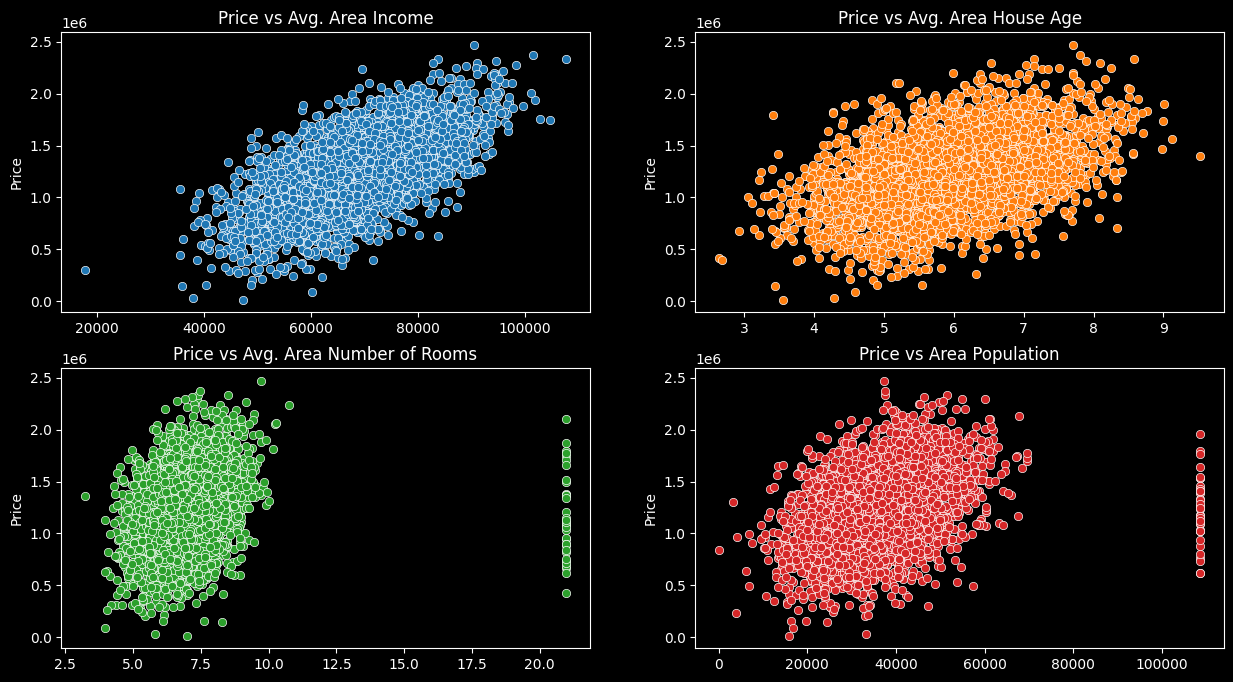

In [185]:
colplot = ['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Area Population']
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# 2 rows and 2 columns
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for i in range(2):
    for j in range(2):
        sns.scatterplot(data=df, x=colplot[i*2 + j], y='Price', color=color[i*2 + j], ax=ax[i, j])
        ax[i, j].set_title(f'Price vs {colplot[i*2 + j]}')
        ax[i, j].set_xlabel('')

Scatter plots are powerful tools for visualizing relationships between variables, helping to uncover patterns, trends, and potential correlations in complex datasets. 

In this case, the plots reveal how housing prices are influenced by different area-level factors. A strong positive correlation is observed with average area income and number of rooms, suggesting that wealthier neighborhoods and larger homes tend to command higher prices. The relationship with house age is moderately positive, while population shows only a weak correlation, indicating that density alone has limited impact on pricing.

Finally few outliers are visible in each plot, which may represent exceptional properties or data anomalies worth further investigation.

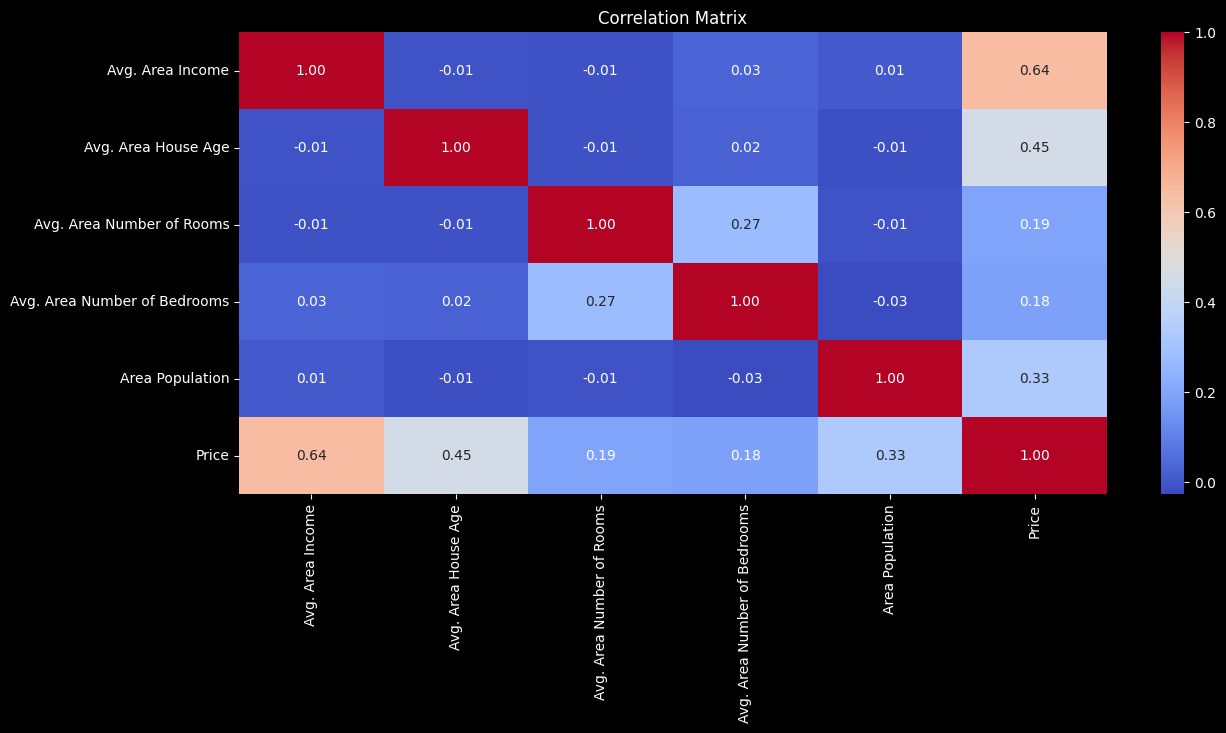

In [186]:
# We need only numerical features for correlation matrix
num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(14, 6))
sns.heatmap(num.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

A correlation heatmap is a valuable tool for quickly identifying relationships between multiple variables, helping analysts detect patterns and guide predictive modeling.

In this case, the heatmap reveals that housing prices are most strongly correlated with average area income (0.64) and the number of rooms (0.56), suggesting that wealth and property size are key drivers of value. Other features, such as area population and number of bedrooms, show weaker correlations with price, indicating a more limited influence. While the matrix highlights general trends, any unusually high or low values outside these patterns may signal outliers or unique market conditions worth closer examination.

In [187]:
def extract_state(s: str) -> str:
    if pd.isna(s):
        return np.nan
    # 1) two-letter code immediately before a 5-digit ZIP (optional -4)
    m = re.search(r'\b([A-Z]{2})\s+\d{5}(?:-\d{4})?\b', s)
    if m:
        return m.group(1)
    # 2) fallback: comma + state
    m = re.search(r',\s*([A-Z]{2})\b', s)
    return m.group(1) if m else np.nan

adress_data = df[['Address', 'Price']].copy()
adress_data['state'] = adress_data['Address'].apply(extract_state)

print(adress_data['state'].unique())
print('\nNb. of states:', adress_data['state'].nunique())

['NE' 'CA' 'WI' 'AP' 'AE' 'KS' 'CO' 'TN' 'AA' 'NM' 'PW' 'AR' 'HI' 'ME'
 'IN' 'MI' 'DE' 'AZ' 'MA' 'MN' 'AL' 'NY' 'NV' 'VA' 'ID' 'OK' 'NH' 'MO'
 'WV' 'WY' 'MH' 'UT' 'SD' 'CT' 'AK' 'WA' 'RI' 'NJ' 'KY' 'NC' 'IA' 'VT'
 'FM' 'ND' 'LA' 'MP' 'OR' 'TX' 'DC' 'PR' 'MT' 'AS' 'OH' 'MS' 'IL' 'VI'
 'GA' 'PA' 'MD' 'SC' 'GU' 'FL']

Nb. of states: 62


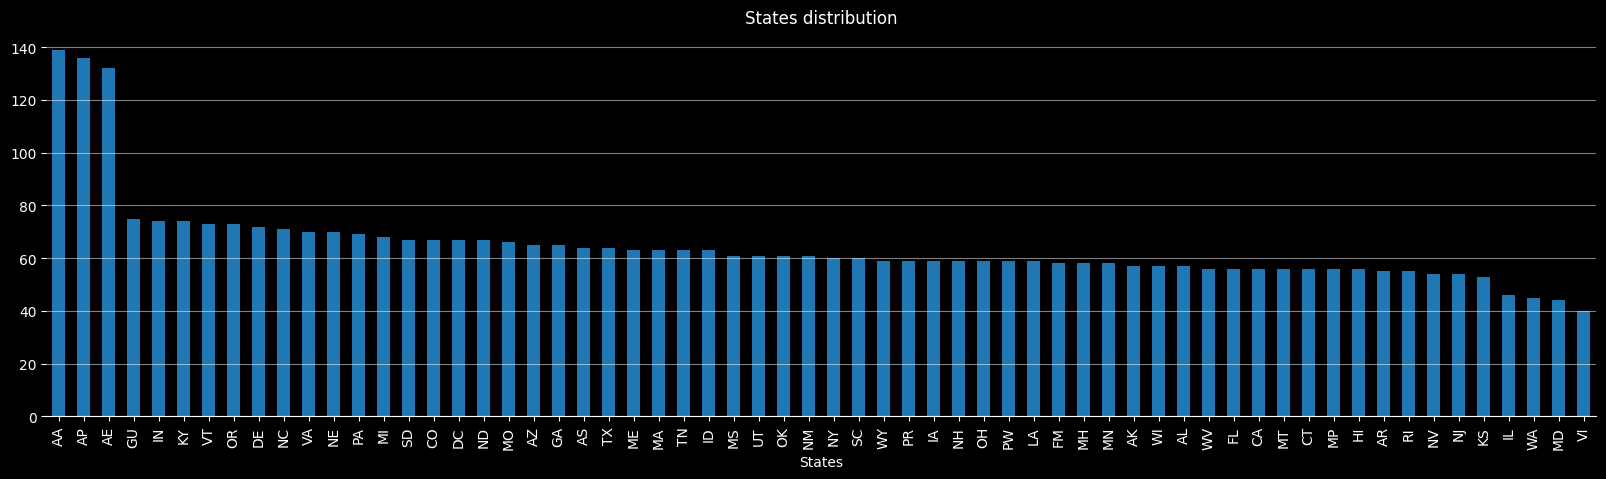

In [188]:
adress_data['state'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(20, 5), color='tab:blue', edgecolor='none')
plt.title('States distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xlabel('States')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.5)
plt.show()


To ensure the consistency of the housing dataset, we restricted the sample to properties located within the 50 U.S. states, the District of Columbia and other US territories. Addresses associated with military or diplomatic codes (AP, AE, AA) were removed, as they do not represent comparable housing markets and could introduce noise into the prediction model. This filtering step allows the analysis to focus on the main U.S. housing market, making the model more reliable and generalizable.

In [189]:
valid_states = adress_data[~adress_data['state'].isin(['AP', 'AE', 'AA'])]['state'].unique().tolist()

# ['NE', 'CA', 'WI', 'KS', 'CO', 'TN', 'NM', 'PW', 'AR', 'HI', 'ME',
# 'IN', 'MI', 'DE', 'AZ', 'MA', 'MN', 'AL', 'NY', 'NV', 'VA', 'ID',
# 'OK', 'NH', 'MO', 'WV', 'WY', 'MH', 'UT', 'SD', 'CT', 'AK', 'WA',
# 'RI', 'NJ', 'KY', 'NC', 'IA', 'VT', 'FM', 'ND', 'LA', 'MP', 'OR',
# 'TX', 'DC', 'PR', 'MT', 'AS', 'OH', 'MS', 'IL', 'VI', 'GA', 'PA',
# 'MD', 'SC', 'GU', 'FL']

In [190]:
filtered = len(adress_data[adress_data['state'].isin(valid_states)])
print(f"Conserved data: {filtered}")

Conserved data: 3593


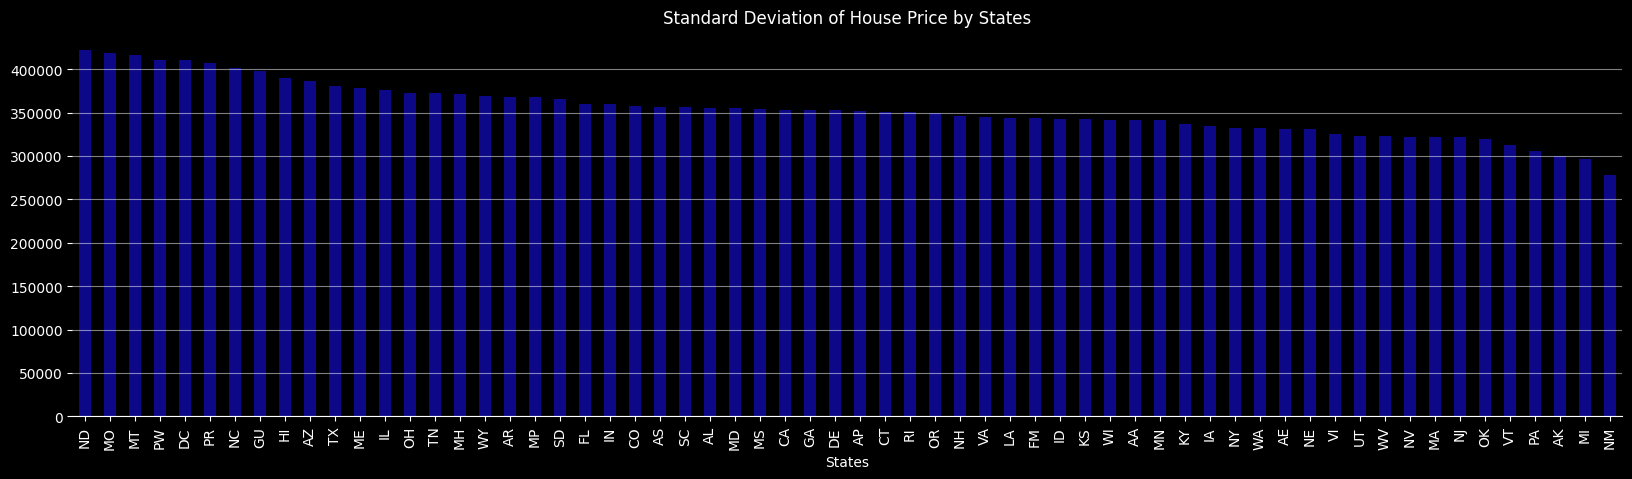

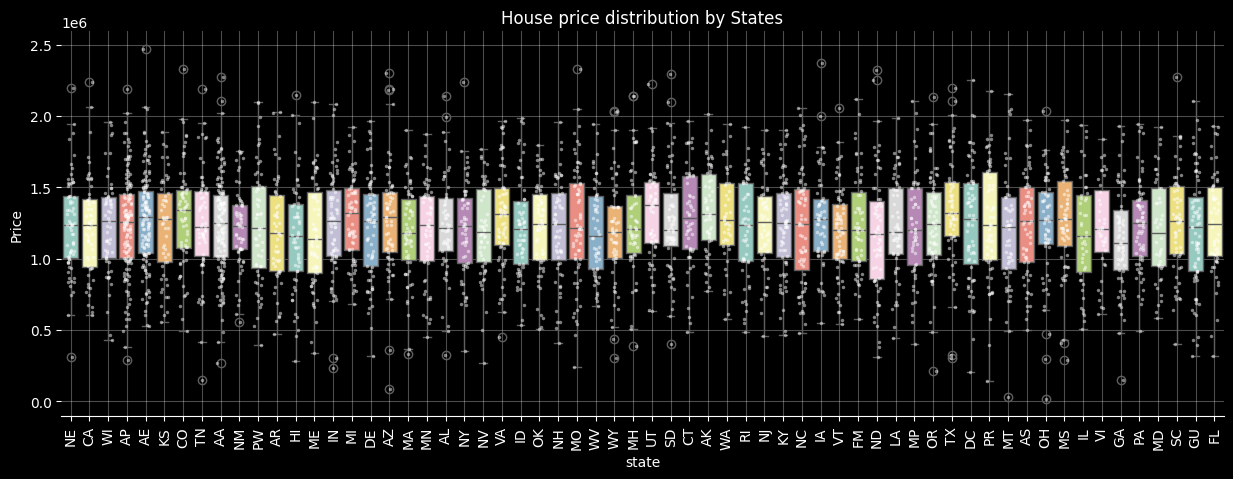

In [191]:
def plot_states(adress_data, metric='mean', var='state', lab='States', boxplot=True, rot=90):
    if metric == 'mean':
        price_b_state = adress_data.groupby(var)['Price'].mean().sort_values(ascending=False)
        metric_lab = 'Average'
    elif metric == 'std':
        price_b_state = adress_data.groupby(var)['Price'].std().sort_values(ascending=False)
        metric_lab = 'Standard Deviation of'
    elif metric == 'count':
        price_b_state = adress_data.groupby(var)['Price'].count().sort_values(ascending=False)
        metric_lab = 'Numb. of available'
    elif metric == 'median':
        price_b_state = adress_data.groupby(var)['Price'].median().sort_values(ascending=False)
        metric_lab = 'Median'
    else:
        raise ValueError("Metric must be 'mean', 'std', or 'count'")
    price_b_state.plot(kind='bar', figsize=(20, 5), cmap='plasma', edgecolor='none')
    plt.title(f'{metric_lab} House Price by {lab}')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xlabel(lab)
    plt.xticks(rotation=rot)
    plt.grid(axis='y', alpha=0.5)
    plt.show()

    if boxplot:
        # plot boxplot by state with points dispertion on the box
        plt.figure(figsize=(15, 5))
        sns.boxplot(data=adress_data, x=var, y='Price', palette='Set3')
        sns.stripplot(data=adress_data, x=var, y='Price', color='white', alpha=0.5, jitter=0.2, size=2.5)
        plt.title(f'House price distribution by {lab}')
        plt.xticks(rotation=90)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.grid(alpha=0.3)
        plt.show()
    
plot_states(adress_data, metric='std')

In order to reduce the dimensionality of the dataset and improve the interpretability of the model, I decided not to keep all U.S. states and territories as separate categories. Instead, I grouped them into the four official U.S. Census regions (Northeast, Midwest, South, and West). U.S. territories such as Puerto Rico, Guam, and the Virgin Islands were placed into a separate category. 

This decision was made after testing different options with the assistance of **<span style="color:blue">ChatGPT</span>**, which highlighted that using regions allows the model to capture meaningful geographic variation while avoiding excessive sparsity caused by rarely represented states or territories.

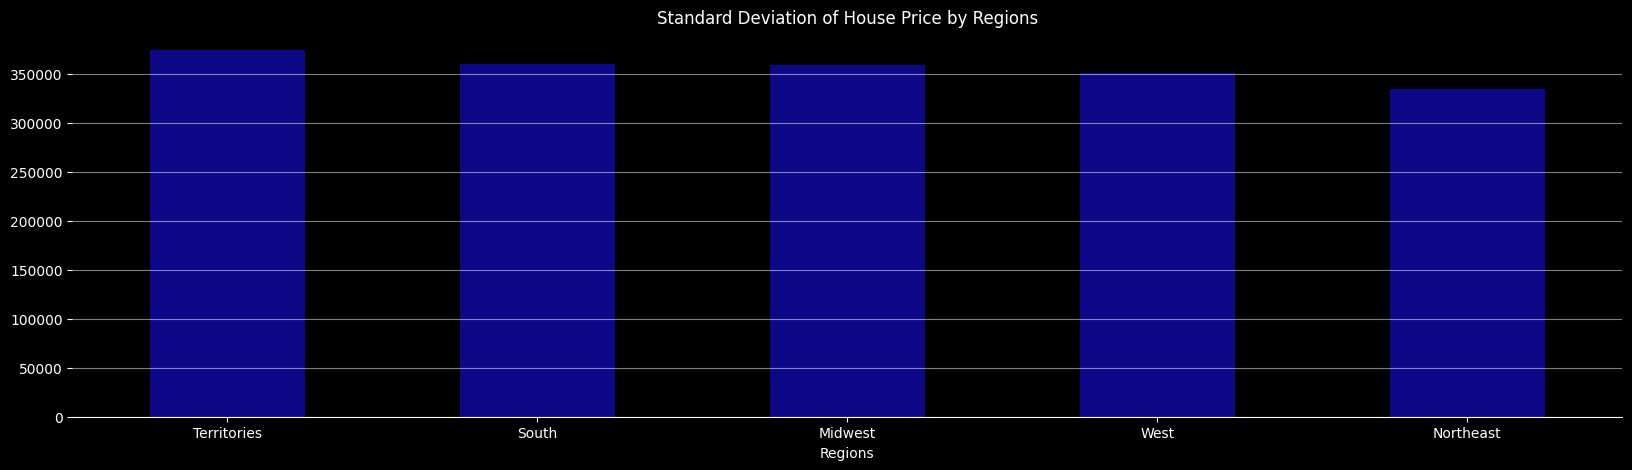

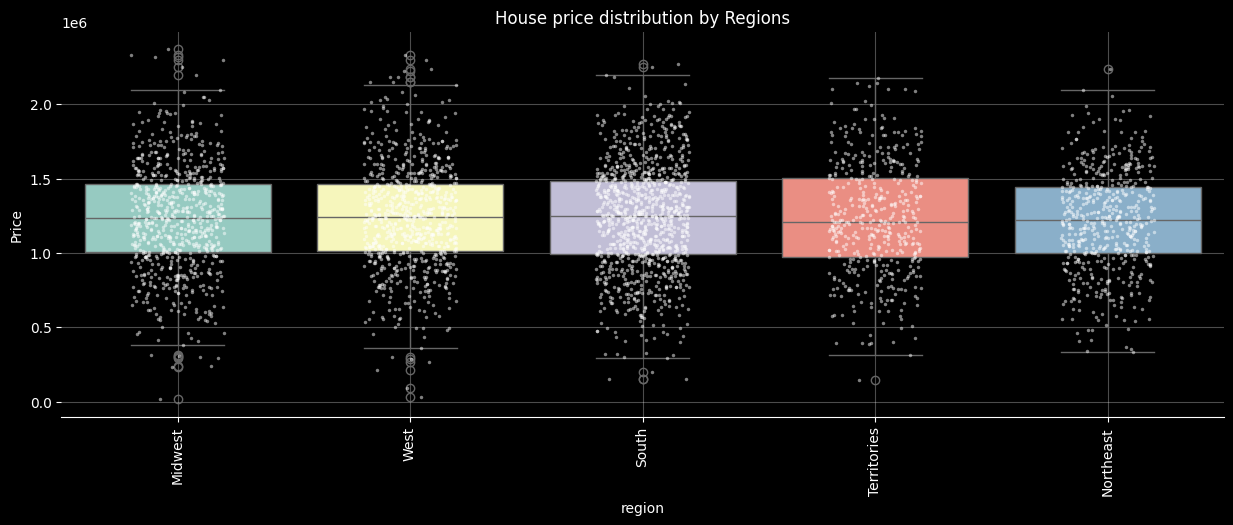

In [192]:
territories = {'PR','GU','VI','AS','MP','FM','MH','PW'}
region_map = {
    # Northeast
    'CT':'Northeast','ME':'Northeast','MA':'Northeast','NH':'Northeast','RI':'Northeast','VT':'Northeast',
    'NJ':'Northeast','NY':'Northeast','PA':'Northeast',
    # Midwest
    'IL':'Midwest','IN':'Midwest','MI':'Midwest','OH':'Midwest','WI':'Midwest',
    'IA':'Midwest','KS':'Midwest','MN':'Midwest','MO':'Midwest','NE':'Midwest','ND':'Midwest','SD':'Midwest',
    # South
    'DE':'South','FL':'South','GA':'South','MD':'South','NC':'South','SC':'South','VA':'South','DC':'South',
    'WV':'South','AL':'South','KY':'South','MS':'South','TN':'South',
    'AR':'South','LA':'South','OK':'South','TX':'South',
    # West
    'AZ':'West','CO':'West','ID':'West','MT':'West','NV':'West','NM':'West','UT':'West','WY':'West',
    'AK':'West','CA':'West','HI':'West','OR':'West','WA':'West'
}

adress_data['region'] = adress_data['state'].map(region_map)
adress_data.loc[adress_data['state'].isin(territories), 'region'] = 'Territories'
plot_states(adress_data, var='region', metric='std', lab='Regions', boxplot=True, rot=0)

In [193]:
filtered_data = adress_data[adress_data['state'].isin(valid_states)].copy()
dft = df.merge(filtered_data[['state']], left_index=True, right_index=True)
dft = dft[dft['state'].isin(valid_states)].copy()
dft.reset_index(drop=True, inplace=True)
dft.drop(columns='state', inplace=True)
dft.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1059033.558,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1058987.988,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,80175.75416,4.988408,6.104512,4.04,26748.42842,1068138.074,"06039 Jennifer Islands Apt. 443\nTracyport, KS..."
4,64698.46343,6.025336,8.147760,3.41,60828.24909,1502055.817,"4759 Daniel Shoals Suite 442\nNguyenburgh, CO ..."


## **<span style="color:blue">Data Preprocessing</span>**

To prepare the dataset for modeling, I will first split it into training and test sets. On the **training set**, I will perform the following preprocessing steps: <span style="color:blue">handle missing values</span> using appropriate imputation techniques, <span style="color:blue">encode categorical variables, <span style="color:blue">detect and treat outliers</span>, apply <span style="color:blue">feature scaling</span>, and select the most relevant features.

Once the preprocessing pipeline is finalized, I will <span style="color:blue">apply the same transformations to the test set</span> to ensure consistency and enable accurate model evaluation.

In [194]:
# Let's split the data into train and test
split_rate = 0.2 # 20% for test
df_ = dft.copy()
train, test = train_test_split(df_, test_size=split_rate, random_state=SEED) # Seed=42 for reproducibility
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (2874, 7), Test shape: (719, 7)


In [195]:
# Let's now create a preprocessing pipeline to prepare the data for modeling
def extract_state(s: str) -> str:
    if pd.isna(s):
        return np.nan
    # 1) two-letter code immediately before a 5-digit ZIP (optional -4)
    m = re.search(r'\b([A-Z]{2})\s+\d{5}(?:-\d{4})?\b', s)
    if m:
        return m.group(1)
    # 2) fallback: comma + state
    m = re.search(r',\s*([A-Z]{2})\b', s)
    return m.group(1) if m else np.nan

class OutlierClipper(BaseEstimator, TransformerMixin):
    """
    Learn per-column clipping bounds on the training set and reuse them at transform time.
    method: 'iqr' (Q1-1.5*IQR, Q3+1.5*IQR) or 'zscore' (mean±k*std) or 'quantile' (q_low, q_high).
    """
    def __init__(self, method: str = 'iqr', z_k: float = 3.0, q_low: float = 0.01, q_high: float = 0.99):
        self.method = method
        self.z_k = z_k
        self.q_low = q_low
        self.q_high = q_high
        self.bounds_ = None          # dict: col -> (lower, upper)
        self.feature_names_in_ = None

    def fit(self, X: pd.DataFrame, y=None):
        if isinstance(X, pd.Series):
            X = X.to_frame()
        self.feature_names_in_ = list(X.columns)
        bounds = {}
        for col in self.feature_names_in_:
            s = pd.to_numeric(X[col], errors='coerce')
            if self.method == 'iqr':
                q1, q3 = s.quantile(0.25), s.quantile(0.75)
                iqr = q3 - q1
                lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
            elif self.method == 'zscore':
                m, sd = s.mean(), s.std(ddof=0)
                lo, hi = m - self.z_k*sd, m + self.z_k*sd
            elif self.method == 'quantile':
                lo, hi = s.quantile(self.q_low), s.quantile(self.q_high)
            else:
                raise ValueError("method must be 'iqr', 'zscore', or 'quantile'")
            bounds[col] = (lo, hi)
        self.bounds_ = bounds
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if isinstance(X, pd.Series):
            X = X.to_frame()
        Xc = X.copy()
        for col in self.feature_names_in_:
            if col in Xc:
                lo, hi = self.bounds_[col]
                Xc[col] = pd.to_numeric(Xc[col], errors='coerce').clip(lower=lo, upper=hi)
        return Xc
    
    def fit_transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        return self.fit(X, y).transform(X)

    # optional: expose the learned bounds
    def get_bounds(self) -> dict:
        return self.bounds_

def preprocess_data(data:pd.DataFrame, train:bool=True, target:str='price', poly:bool=True) -> pd.DataFrame:
    """
    This function preprocesses the data for modeling. 
    It handles missing values, encodes categorical variables, scales numerical features, and create polynomial features.

    Args:
    data : pd.DataFrame)
        The input dataframe to preprocess.
    train :bool, optional
        Whether the data is for training or testing. Default is True.

    Returns:
        pd.DataFrame: The preprocessed dataframe.
    """
    data = data.copy()
    # 1. processing address to extract state regions
    if 'Address' in data.columns:
        data['state'] = data['Address'].apply(extract_state)
        data.drop(columns=['Address'], inplace=True)
    else:
        raise ValueError("The dataframe must contain an 'Address' column.")
    
    territories = {'PR','GU','VI','AS','MP','FM','MH','PW'}
    region_map = {
        # Northeast
        'CT':'Northeast','ME':'Northeast','MA':'Northeast','NH':'Northeast','RI':'Northeast','VT':'Northeast',
        'NJ':'Northeast','NY':'Northeast','PA':'Northeast',
        # Midwest
        'IL':'Midwest','IN':'Midwest','MI':'Midwest','OH':'Midwest','WI':'Midwest',
        'IA':'Midwest','KS':'Midwest','MN':'Midwest','MO':'Midwest','NE':'Midwest','ND':'Midwest','SD':'Midwest',
        # South
        'DE':'South','FL':'South','GA':'South','MD':'South','NC':'South','SC':'South','VA':'South','DC':'South',
        'WV':'South','AL':'South','KY':'South','MS':'South','TN':'South',
        'AR':'South','LA':'South','OK':'South','TX':'South',
        # West
        'AZ':'West','CO':'West','ID':'West','MT':'West','NV':'West','NM':'West','UT':'West','WY':'West',
        'AK':'West','CA':'West','HI':'West','OR':'West','WA':'West'
    }
    data['region'] = data['state'].map(region_map)
    data.loc[data['state'].isin(territories), 'region'] = 'Territories'
    data.drop(columns=['state'], inplace=True)
    
    # 2. Renaming columns
    verified_colnames = ['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Avg. Area Number of Bedrooms', 'Area Population', 'Price', 'region']
    colnames = ['avg_income', 'house_age', 'nof_rooms', 'nof_bedrooms', 'population', 'price', 'region']
    
    # 3. ensure the good columns are present
    if train:
        assert all([col in data.columns for col in verified_colnames]), f"Some columns are missing in the training data.\nAvailable colomns: {data.columns.tolist()}"
        data.columns = colnames
    else:
        verified_colnames = [col for col in verified_colnames if col != 'Price']
        assert all([col in data.columns for col in verified_colnames]), f"Some columns are missing in the testing data.\nAvailable colomns: {data.columns.tolist()}"
        data.columns = [col for col in colnames if col != 'price']
    
    if train:
        X = data.drop(columns=[target])
        X_num = X.select_dtypes(include=[np.number])
        X_cat = X.select_dtypes(include=['object'])
        y = data[target]
        
        # 4. Handling missing values
        imputer = KNNImputer(n_neighbors=5)
        X_imputed = pd.DataFrame(imputer.fit_transform(X_num), columns=X_num.columns)
        
        # 5. Dealing with outliers
        clipper = OutlierClipper(method='zscore', z_k=2.25)
        X_out = clipper.fit_transform(X_imputed)
        
        # 6. Encoding categorical variables
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        state_encoded = pd.DataFrame(encoder.fit_transform(X_cat), columns=encoder.get_feature_names_out(['region']))
        X = pd.concat([X_out.reset_index(drop=True), state_encoded.reset_index(drop=True)], axis=1)
        
        # 7. Scaling numerical features
        scaler = StandardScaler()
        num_cols = X_num.columns
        X[num_cols] = scaler.fit_transform(X[num_cols])
        
        # 8. Create polynomial features
        if poly:       
            poly = PolynomialFeatures(degree=2, include_bias=False)
            X_poly = poly.fit_transform(X)
            feature_names = poly.get_feature_names_out(input_features=X.columns)
            X_poly = pd.DataFrame(X_poly, columns=feature_names)
        else:
            X_poly = X.copy()
            feature_names = X.columns.tolist()
            poly = None

        data = X_poly
        data[target] = y.values
        
        # Save all
        os.makedirs('models/transforms', exist_ok=True)
        if poly:
            processor = {'encoder': encoder, 'imputer': imputer, 'scaler': scaler, 
                        'clipper': clipper, 'poly': poly, 'x_names': feature_names}
            joblib.dump(processor, 'models/transforms/processor_pol.pkl')
        else:
            processor = {'encoder': encoder, 'imputer': imputer, 'scaler': scaler, 
                        'clipper': clipper}
            joblib.dump(processor, 'models/transforms/processor.pkl')
        
    else:
        # Load the processor
        if poly:
            processor = joblib.load('models/transforms/processor_pol.pkl')
        else:
            processor = joblib.load('models/transforms/processor.pkl')
        encoder = processor['encoder']
        imputer = processor['imputer']
        scaler = processor['scaler']
        clipper = processor['clipper']
        
        X = data
        X_num = X.select_dtypes(include=[np.number])
        X_cat = X.select_dtypes(include=['object'])
        
        # 4. Handling missing values
        X_imputed = pd.DataFrame(imputer.transform(X_num), columns=X_num.columns)
        X = pd.concat([X_imputed.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
        
        # 5. Dealing with outliers
        X_out = clipper.transform(X_imputed)
        
        # 6. Encoding categorical variables
        state_encoded = pd.DataFrame(encoder.transform(X_cat), columns=encoder.get_feature_names_out(['region']))
        X = pd.concat([X_out.reset_index(drop=True), state_encoded.reset_index(drop=True)], axis=1)
        
        # 7. Scaling numerical features
        num_cols = X_num.columns
        X[num_cols] = scaler.transform(X[num_cols])
        
        # 8. Create polynomial features
        if poly:       
            poly = processor['poly']
            feature_names = processor['x_names']
            X_poly = poly.transform(X)
            X_poly = pd.DataFrame(X_poly, columns=feature_names)
        else:
            X_poly = X.copy()
        
        data = X_poly
        
    return data

In [196]:
train_p = preprocess_data(train, True)
X_train = train_p.drop(columns=['price'])
y_train = train_p['price'].rename('price')

X_test = test.drop(columns=['Price'])
y_test = test['Price'].rename('price')
X_test = preprocess_data(X_test, False)

print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes: X_train: (2874, 65), y_train: (2874,), X_test: (719, 65), y_test: (719,)


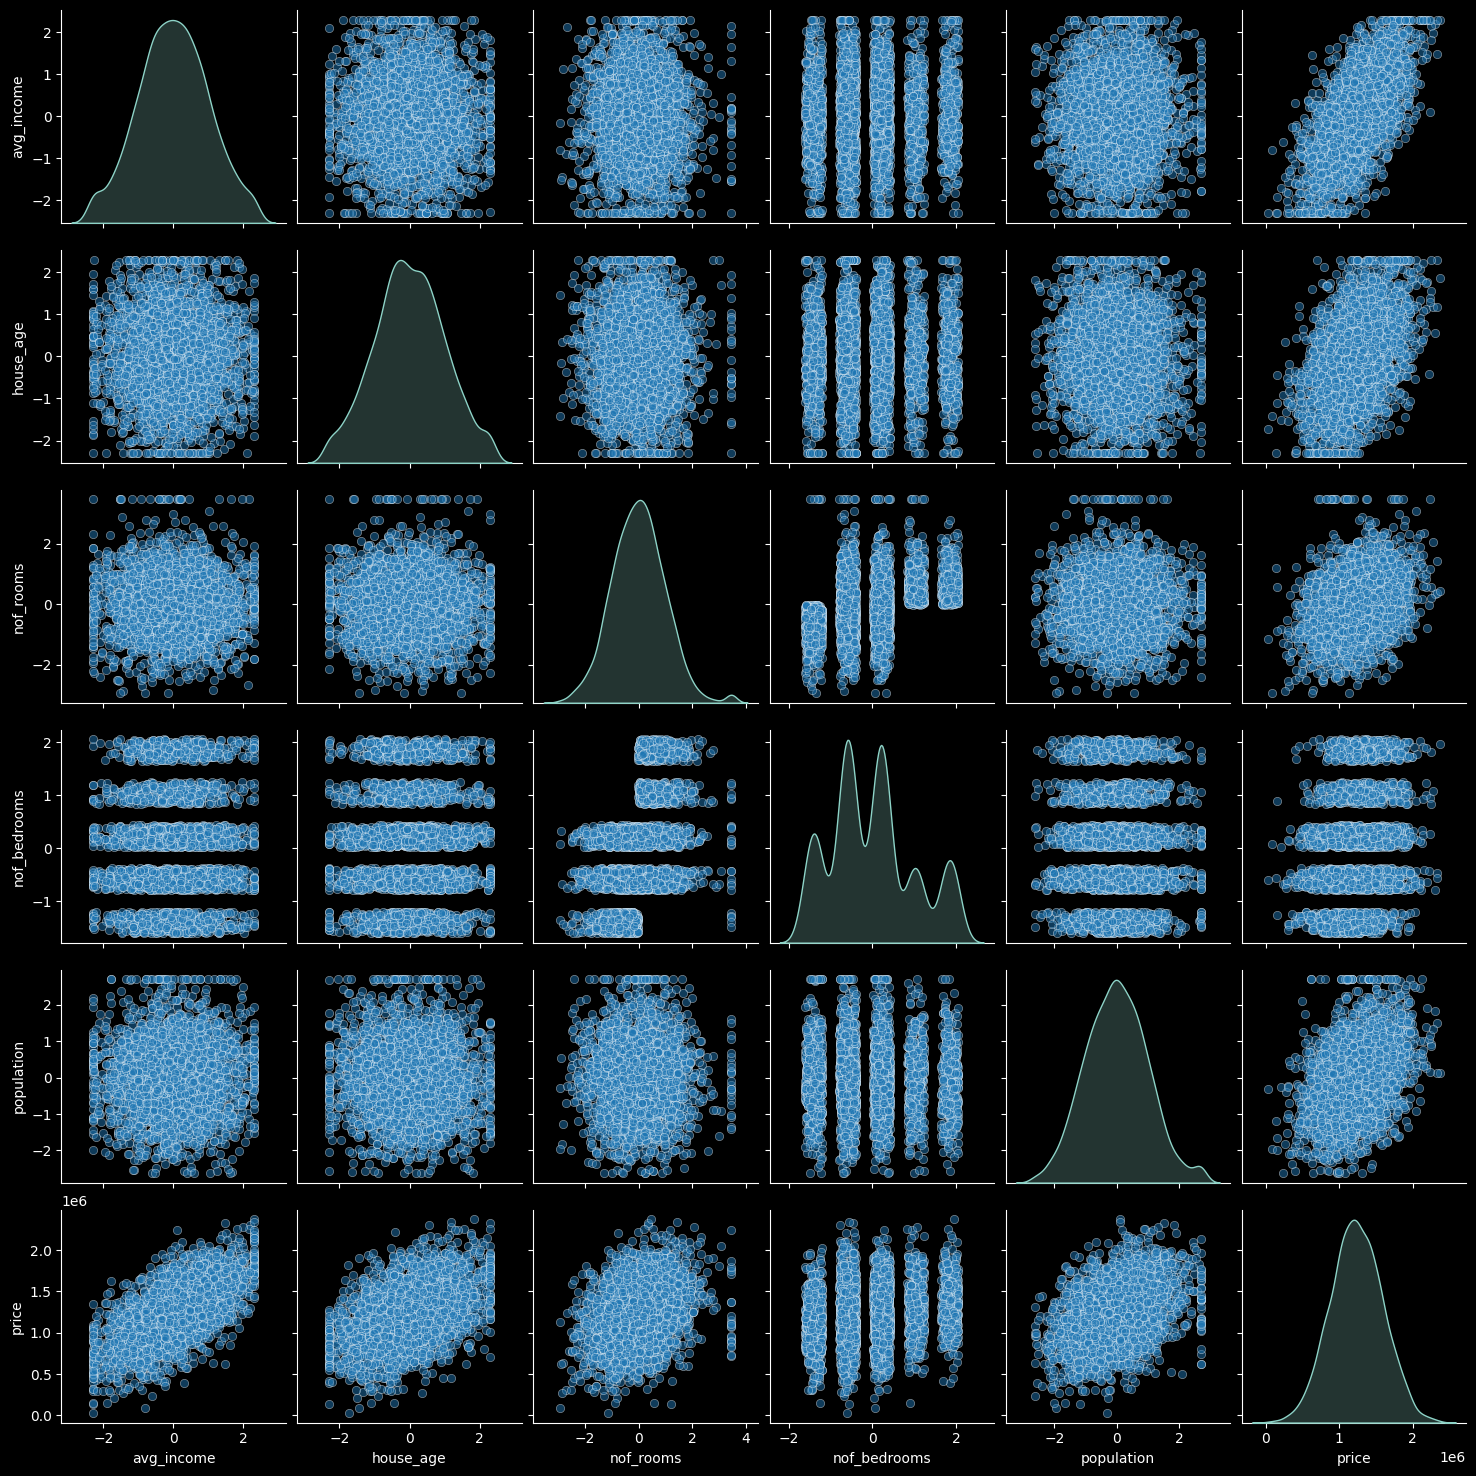

In [197]:
X_t = preprocess_data(train, train=True, poly=False)
region_col = ['region_Midwest', 'region_Northeast', 'region_South', 'region_Territories', 'region_West']
sns.pairplot(X_t.drop(columns=region_col), diag_kind='kde', plot_kws={'alpha':0.5, 'color':'tab:blue'})
plt.show()

In [198]:
X_train.shape, X_test.shape

((2874, 65), (719, 65))

## **<span style="color:blue">Modelisation</span>**

Here we are going to try different regression models to predict house prices based on the preprocessed features. We will evaluate each model's performance using metrics such as Mean Squared Error (MSE) and R-squared (R²) to determine which model provides the most accurate predictions.

4 different models will be tested: 
- Linear Regression
- Bayesian Ridge Regression
- Random Forest Regressor
- Gradient Boosting Regressor
- K-Nearest Neighbors Regressor

First, cause we have a lot of features, we are going to use some technics (PCA, SelectKBest,...) to reduce the number of features and see if it improve the models. This will help to reduce the complexity of the models, training time and potentially improve performance by eliminating noise and redundant features. 

Then, we will perform hyperparameter tuning using RandomizedSearchCV to optimize each model's performance. This involves testing different combinations of hyperparameters to find the best settings for each algorithm.

Finally, we will compare the performance of all models on the test set to identify the most effective approach for predicting house prices in this dataset.

In [199]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE

### Linear Regression

In [200]:
lr = LinearRegression()
lr.fit(X_train, y_train)

scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Linear Regression CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")

y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("LinearRegression Metrics")
print(f"Test MSE: {mse_lr:.2f}\nTest R2: {r2_lr:.4f}")

*******Linear Regression CV*******
Mean MSE: 13916869411.37
Std: 866138431.61
LinearRegression Metrics
Test MSE: 16769186965.18
Test R2: 0.8690


Here, using all features, the Linear Regression model achieved a R² of 86.9%. Let's see if we can improve this by selecting the most relevant features.

#### **Using PCA best components (90% variance)**

Here we use PCA to reduce the dimensionality of the dataset while retaining 90% of the variance. This helps to simplify the model and potentially improve performance by eliminating noise and redundant features.

In [201]:
# PCA 90%
pca = PCA(n_components=0.9, random_state=SEED)
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca, columns=X_train_pca.columns)
print(f"PCA reduced the number of features from {X_train.shape[1]} to {X_train_pca.shape[1]}")

PCA reduced the number of features from 65 to 27


In [202]:
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

scores = cross_val_score(lr, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Linear Regression CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")

y_pred_lr = lr.predict(X_test_pca)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("LinearRegression Metrics")
print(f"Test MSE: {mse_lr:.2f}\nTest R2: {r2_lr:.4f}")

*******Linear Regression CV*******
Mean MSE: 14579724392.65
Std: 678985570.36
LinearRegression Metrics
Test MSE: 16952248452.92
Test R2: 0.8676


#### **Using Lasso for feature selection**

In this approach, I used Lasso regression to identify and select the most important features for predicting house prices. Lasso helps in feature selection by shrinking the coefficients of less important features to zero, effectively removing them from the model. This results in a more interpretable model that focuses on the key predictors of house prices.

In [203]:
lasso = LassoCV(cv=30, random_state=SEED).fit(X_train, y_train)
selected_features_lass = X_train.columns[lasso.coef_ != 0]
print("Features selected:", selected_features_lass.tolist())
(f"{len(selected_features_lass)} features selected.")

Features selected: ['avg_income', 'house_age', 'nof_rooms', 'nof_bedrooms', 'population', 'avg_income population', 'avg_income region_Territories', 'house_age^2', 'house_age nof_rooms', 'house_age population', 'nof_rooms^2', 'nof_rooms nof_bedrooms', 'nof_bedrooms^2', 'nof_bedrooms population', 'population^2']


'15 features selected.'

Let's train a Linear Regression model using the selected features and evaluate its performance on the test set.

In [204]:
lr = LinearRegression()
lr.fit(X_train[selected_features_lass], y_train)

scores = cross_val_score(lr, X_train[selected_features_lass], y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Linear Regression CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")

y_pred_lr = lr.predict(X_test[selected_features_lass])
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("LinearRegression Metrics")
print(f"Test MSE: {mse_lr:.2f}\nTest R2: {r2_lr:.4f}")

*******Linear Regression CV*******
Mean MSE: 13706926695.52
Std: 833735887.38
LinearRegression Metrics
Test MSE: 16637799651.53
Test R2: 0.8701


We constat that using Lasso for feature selection improved the model's performance, achieving a R² of 87.5% on the test set. This indicates that selecting relevant features can enhance the predictive accuracy of the model.

#### **Using RFEcv for feature selection**

In [205]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=30)  # garder 15
rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_]
print("Features selected:", selected_features_rfe.tolist())
print(f"{len(selected_features_rfe)} features selected.")

Features selected: ['avg_income', 'house_age', 'nof_rooms', 'population', 'avg_income region_Midwest', 'avg_income region_Northeast', 'avg_income region_South', 'avg_income region_Territories', 'avg_income region_West', 'house_age region_Midwest', 'house_age region_Northeast', 'house_age region_South', 'house_age region_Territories', 'house_age region_West', 'nof_rooms^2', 'nof_rooms nof_bedrooms', 'nof_rooms region_Midwest', 'nof_rooms region_Northeast', 'nof_rooms region_South', 'nof_rooms region_Territories', 'nof_rooms region_West', 'nof_bedrooms^2', 'population^2', 'population region_Midwest', 'population region_Northeast', 'population region_South', 'population region_Territories', 'population region_West', 'region_Northeast^2', 'region_Territories^2']
30 features selected.


In [206]:
lr = LinearRegression()
lr.fit(X_train[selected_features_rfe], y_train)

scores = cross_val_score(lr, X_train[selected_features_rfe], y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Linear Regression CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")

y_pred_lr = lr.predict(X_test[selected_features_rfe])
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("LinearRegression Metrics")
print(f"Test MSE: {mse_lr:.2f}\nTest R2: {r2_lr:.4f}")

*******Linear Regression CV*******
Mean MSE: 13843627924.26
Std: 974884005.16
LinearRegression Metrics
Test MSE: 16645895813.70
Test R2: 0.8700


Here the model achieved better performance (R² = 87%) than using all features (R² = 86.9%), but slightly worse cause we selected 30 features instead of 15 with Lasso.

#### **Conclusion**

In conclusion, after applying various feature selection techniques and training a Linear Regression model, we found that using Lasso for feature selection yielded the best performance.

In [207]:
lr = LinearRegression()
lr.fit(X_train[selected_features_lass], y_train)

scores = cross_val_score(lr, X_train[selected_features_lass], y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Linear Regression CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")

y_pred_lr = lr.predict(X_test[selected_features_lass])
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("LinearRegression Metrics")
print(f"Test MSE: {mse_lr:.2f}\nTest R2: {r2_lr:.4f}")

*******Linear Regression CV*******
Mean MSE: 13706926695.52
Std: 833735887.38
LinearRegression Metrics
Test MSE: 16637799651.53
Test R2: 0.8701


### Bayesian Ridge Regression

In [208]:
brr = BayesianRidge()
brr.fit(X_train, y_train)

scores = cross_val_score(brr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Bayesian Ridge Regression CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")

y_pred_brr = brr.predict(X_test)
mse_brr = mean_squared_error(y_test, y_pred_brr)
r2_brr = r2_score(y_test, y_pred_brr)
coefs = pd.Series(brr.coef_, index=X_train.columns) # save the coefficients
print("BayesianRidge Metrics")
print(f"Test MSE: {mse_brr:.2f}\nTest R2: {r2_brr:.4f}")

*******Bayesian Ridge Regression CV*******
Mean MSE: 13912385564.04
Std: 855195075.97
BayesianRidge Metrics
Test MSE: 16753518990.58
Test R2: 0.8692


Using all features, the Bayesian Ridge Regression model achieved a R² of 86.92%.

#### **Using PCA best components (90% variance)**

In [209]:
brr = BayesianRidge()
brr.fit(X_train_pca, y_train)

scores = cross_val_score(brr, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Bayesian Ridge Regression CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")

y_pred_brr = brr.predict(X_test_pca)
mse_brr = mean_squared_error(y_test, y_pred_brr)
r2_brr = r2_score(y_test, y_pred_brr)
print("BayesianRidge Metrics")
print(f"Test MSE: {mse_brr:.2f}\nTest R2: {r2_brr:.4f}")

*******Bayesian Ridge Regression CV*******
Mean MSE: 14579305464.98
Std: 674644187.93
BayesianRidge Metrics
Test MSE: 16949052903.21
Test R2: 0.8676


#### **Using Lasso for feature selection**

In [210]:
print("Features selected:", list(selected_features_lass))

Features selected: ['avg_income', 'house_age', 'nof_rooms', 'nof_bedrooms', 'population', 'avg_income population', 'avg_income region_Territories', 'house_age^2', 'house_age nof_rooms', 'house_age population', 'nof_rooms^2', 'nof_rooms nof_bedrooms', 'nof_bedrooms^2', 'nof_bedrooms population', 'population^2']


In [211]:
brr = BayesianRidge()
brr.fit(X_train[selected_features_lass], y_train)

scores = cross_val_score(brr, X_train[selected_features_lass], y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Bayesian Ridge Regression CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")

y_pred_brr = brr.predict(X_test[selected_features_lass])
mse_brr = mean_squared_error(y_test, y_pred_brr)
r2_brr = r2_score(y_test, y_pred_brr)
print("BayesianRidge Metrics")
print(f"Test MSE: {mse_brr:.2f}\nTest R2: {r2_brr:.4f}")

*******Bayesian Ridge Regression CV*******
Mean MSE: 13706838858.10
Std: 831220111.12
BayesianRidge Metrics
Test MSE: 16634479176.87
Test R2: 0.8701


The features selected in the Lasso have been used to train the BBR model and the model achieved a better R² than using all features (87% vs 86.92%).

### Random Forest Regressor

First of all, let's train a simple RF model using all features and see how it performs.

In [220]:
simple_rf = RandomForestRegressor(random_state=SEED)
simple_rf.fit(X_train, y_train)
scores = cross_val_score(simple_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("*******Random Forest CV*******")
print(f"Mean MSE: {-scores.mean():.2f}\nStd: {scores.std():.2f}")
y_pred_rf = simple_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("RandomForestRegressor Metrics")
print(f"Test MSE: {mse_rf:.2f}\nTest R2: {r2_rf:.4f}")

*******Random Forest CV*******
Mean MSE: 18371038028.67
Std: 746489135.97
RandomForestRegressor Metrics
Test MSE: 19349262305.64
Test R2: 0.8489


#### **Using PCA best components (90% variance)**

In [221]:
# # Finding best hyperparameters for the RandomForestRegressor model
# random_rf = RandomForestRegressor(random_state=SEED)

# param_dist = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }
# rand_search_rf = RandomizedSearchCV(random_rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
# rand_search_rf.fit(X_train_pca, y_train)

# print(f"Best hyperparameters for RandomForestRegressor: {rand_search_rf.best_params_}")
# print(f"Best CV MSE: {-rand_search_rf.best_score_:.2f}")

In [222]:
# Training the model with the best hyperparameters
# rf_model = rand_search_rf.best_estimator_
best_params = {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
rf_model = RandomForestRegressor(**best_params, random_state=SEED)
rf_model.fit(X_train_pca, y_train)

y_pred_rf = rf_model.predict(X_test_pca)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("RandomForestRegressor Metrics")
print(f"Test MSE: {mse_rf:.2f}\nTest R2: {r2_rf:.4f}")

RandomForestRegressor Metrics
Test MSE: 18435228932.37
Test R2: 0.8560


#### **Using Lasso for feature selection**

In [223]:
# # Finding best hyperparameters for the RandomForestRegressor model
# random_rf = RandomForestRegressor(random_state=SEED)

# param_dist = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }
# rand_search_rf = RandomizedSearchCV(random_rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
# rand_search_rf.fit(X_train[selected_features_lass], y_train)

# print(f"Best hyperparameters for RandomForestRegressor: {rand_search_rf.best_params_}")
# print(f"Best CV MSE: {-rand_search_rf.best_score_:.2f}")

In [224]:
# Training the model with the best hyperparameters
# rf_model = rand_search_rf.best_estimator_
best_params = {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
rf_model = RandomForestRegressor(**best_params, random_state=SEED)
rf_model.fit(X_train[selected_features_lass], y_train)

y_pred_rf = rf_model.predict(X_test[selected_features_lass])
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("RandomForestRegressor Metrics")
print(f"Test MSE: {mse_rf:.2f}\nTest R2: {r2_rf:.4f}")

RandomForestRegressor Metrics
Test MSE: 18840844133.67
Test R2: 0.8529


#### **Using a RF feature importance for feature selection**

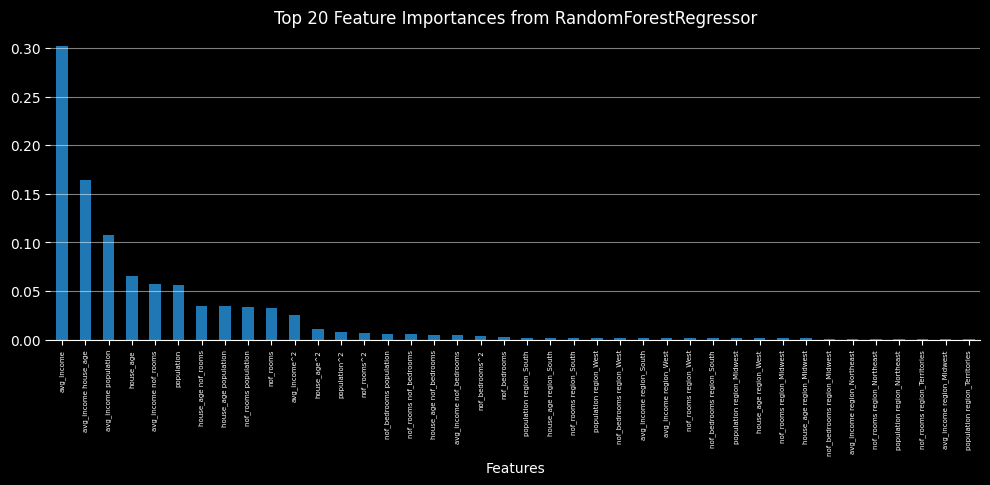

In [225]:
# Features importance from simple RFR
importances = pd.Series(simple_rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)
plt.figure(figsize=(12, 4))
importances.head(40).plot(kind='bar', color='tab:blue', edgecolor='none')
plt.title('Top 20 Feature Importances from RandomForestRegressor')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xlabel('Features')
plt.xticks(rotation=90, fontsize=5)
plt.grid(axis='y', alpha=0.5)
plt.show()

In [226]:
# list_a = list(range(5, 30))
# r2_dict = {}
# for a in list_a:
#     print("\n=============================")
#     print(f"Top {a} features")
#     select = importances.head(a).index.tolist()
#     rf_model = RandomForestRegressor(random_state=SEED)
#     rf_model.fit(X_train[select], y_train)
#     scores = cross_val_score(rf_model, X_train[select], y_train, cv=5, scoring='r2')
#     print(f"Mean R2: {scores.mean():.2f}\nStd: {scores.std():.2f}")

#     y_pred_rf = rf_model.predict(X_test[select])
#     mse_rf = mean_squared_error(y_test, y_pred_rf)
#     r2_rf = r2_score(y_test, y_pred_rf)
#     print(f"Test R2: {r2_rf:.4f}")
#     # stock the best r2 only
#     if a not in r2_dict or r2_rf > r2_dict[a][1]:
#         r2_dict[a] = (a, select, r2_rf)
        
# best_num_features = max(r2_dict.keys(), key=lambda k: r2_dict[k][2])
# best_features = r2_dict[best_num_features][1]
# print(f"\nBest R2 achieved with {best_num_features} features: {r2_dict[best_num_features][2]:.4f}")

After runing this program we obtained that the 13 most important features selected by the simple RF model are the best ones. Let's now find the best hyperparameters for this model using RandomizedSearchCV.

In [227]:
selected_by_rf = importances.head(13).index.tolist()

In [228]:
# # Finding best hyperparameters for the RandomForestRegressor model
# random_rf = RandomForestRegressor(random_state=SEED)

# param_dist = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }
# rand_search_rf = RandomizedSearchCV(random_rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
# rand_search_rf.fit(X_train[selected_by_rf], y_train)

# print(f"Best hyperparameters for RandomForestRegressor: {rand_search_rf.best_params_}")
# print(f"Best CV MSE: {-rand_search_rf.best_score_:.2f}")

In [229]:
# Training the model with the best hyperparameters
# rf_model = rand_search_rf.best_estimator_

best_params = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
rf_model = RandomForestRegressor(**best_params, random_state=SEED)
rf_model.fit(X_train[selected_by_rf], y_train)

y_pred_rf = rf_model.predict(X_test[selected_by_rf])
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("RandomForestRegressor Metrics")
print(f"Test MSE: {mse_rf:.2f}\nTest R2: {r2_rf:.4f}")

RandomForestRegressor Metrics
Test MSE: 18562795666.01
Test R2: 0.8550


#### **Conclusion**

The RFR model trained using PCA-reduced features achieved a R² of 85.6%, and is most efficient but uses 27 features. The RFR model trained using the 13 most important features selected by a simple RF model achieved a R² of 85.5%, and is the most efficient as it only uses 13 features.

### Gradient Boosting Regressor

#### **Using GBR feature importance for feature selection**

In [230]:
# # Finding best hyperparameters
# random_xgb = XGBRegressor(objective='reg:squarederror', random_state=SEED)
# param_dist = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.01, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2, 3]
# }
# rand_search_xgb = RandomizedSearchCV(random_xgb, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
# rand_search_xgb.fit(X_train, y_train)

# xgb_model = rand_search_xgb.best_estimator_
# xgb_model.fit(X_train, y_train)
# y_pred_xgb = xgb_model.predict(X_test)

In [231]:
# importance = xgb_model.feature_importances_
# important_features = X_train.columns[importance > 0.01]
important_features = ['avg_income', 'house_age', 'nof_rooms', 'population', 'avg_income^2', 'avg_income house_age', 'avg_income nof_rooms', 'avg_income population', 'house_age^2', 'house_age nof_rooms', 'house_age population', 'nof_rooms population']
print("Important features:", important_features)
print(f"{len(important_features)} features selected.")

Important features: ['avg_income', 'house_age', 'nof_rooms', 'population', 'avg_income^2', 'avg_income house_age', 'avg_income nof_rooms', 'avg_income population', 'house_age^2', 'house_age nof_rooms', 'house_age population', 'nof_rooms population']
12 features selected.


In [232]:
# # Finding best hyperparameters
# random_xgb = XGBRegressor(objective='reg:squarederror', random_state=SEED)
# param_dist = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.01, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2, 3]
# }
# rand_search_xgb = RandomizedSearchCV(random_xgb, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
# rand_search_xgb.fit(X_train[important_features], y_train)
# print(f"Best hyperparameters for XGBRegressor: {rand_search_xgb.best_params_}")
# print(f"Best CV MSE: {-rand_search_xgb.best_score_:.2f}")

In [233]:
# Training the model with the best hyperparameters
# xgb_model = rand_search_xgb.best_estimator_
best_params = {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=SEED, **best_params)
xgb_model.fit(X_train[important_features], y_train)

y_pred_xgb = xgb_model.predict(X_test[important_features])
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBRegressor Metrics")
print(f"Test MSE: {mse_xgb:.2f}\nTest R2: {r2_xgb:.4f}")

XGBRegressor Metrics
Test MSE: 16132585763.31
Test R2: 0.8740


#### **Using Lasso for feature selection**

In [234]:
# # Finding best hyperparameters
# random_xgb = XGBRegressor(objective='reg:squarederror', random_state=SEED)
# param_dist = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.01, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2, 3]
# }
# rand_search_xgb = RandomizedSearchCV(random_xgb, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
# rand_search_xgb.fit(X_train[selected_features_lass], y_train)
# print(f"Best hyperparameters for XGBRegressor: {rand_search_xgb.best_params_}")
# print(f"Best CV MSE: {-rand_search_xgb.best_score_:.2f}")

In [235]:
# Training the model with the best hyperparameters
# xgb_model = rand_search_xgb.best_estimator_
best_params = {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=SEED, **best_params)
xgb_model.fit(X_train[selected_features_lass], y_train)

y_pred_xgb = xgb_model.predict(X_test[selected_features_lass])
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBRegressor Metrics")
print(f"Test MSE: {mse_xgb:.2f}\nTest R2: {r2_xgb:.4f}")

XGBRegressor Metrics
Test MSE: 15709611062.67
Test R2: 0.8773


#### **Using best features from the RFR model**

In [236]:
print(selected_by_rf)

['avg_income', 'avg_income house_age', 'avg_income population', 'house_age', 'avg_income nof_rooms', 'population', 'house_age nof_rooms', 'house_age population', 'nof_rooms population', 'nof_rooms', 'avg_income^2', 'house_age^2', 'population^2']


In [237]:
# # Finding best hyperparameters
# random_xgb = XGBRegressor(objective='reg:squarederror', random_state=SEED)
# param_dist = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.01, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2, 3]
# }
# rand_search_xgb = RandomizedSearchCV(random_xgb, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
# rand_search_xgb.fit(X_train[selected_by_rf], y_train)
# print(f"Best hyperparameters for XGBRegressor: {rand_search_xgb.best_params_}")
# print(f"Best CV MSE: {-rand_search_xgb.best_score_:.2f}")

In [238]:
# Training the model with the best hyperparameters
# xgb_model = rand_search_xgb.best_estimator_
best_params = {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=SEED, **best_params)
xgb_model.fit(X_train[selected_by_rf], y_train)

y_pred_xgb = xgb_model.predict(X_test[selected_by_rf])
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBRegressor Metrics")
print(f"Test MSE: {mse_xgb:.2f}\nTest R2: {r2_xgb:.4f}")

XGBRegressor Metrics
Test MSE: 15448856423.77
Test R2: 0.8794


#### **Conclusion**



The model trained using the RFR selected features achieved a R² of 87.9%.

### KNN

In [239]:
simple_knn = KNeighborsRegressor()
simple_knn.fit(X_train, y_train)

y_pred_knn = simple_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNeighborsRegressor Metrics")
print(f"Test MSE: {mse_knn:.2f}\nTest R2: {r2_knn:.4f}")

KNeighborsRegressor Metrics
Test MSE: 27010821602.64
Test R2: 0.7891


#### **Using PCA best components (90% variance)**

In [240]:
# Finding best hyperparameters for the KNeighborsRegressor model
random_knn = KNeighborsRegressor()
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}
rand_search_knn = RandomizedSearchCV(random_knn, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
rand_search_knn.fit(X_train_pca, y_train)

print(f"Best hyperparameters for KNeighborsRegressor: {rand_search_knn.best_params_}")
print(f"Best CV MSE: {-rand_search_knn.best_score_:.2f}")

Best hyperparameters for KNeighborsRegressor: {'weights': 'distance', 'p': 2, 'n_neighbors': 11}
Best CV MSE: 21150573737.59


In [241]:
# Training the model with the best hyperparameters
knn_model = rand_search_knn.best_estimator_
knn_model.fit(X_train_pca, y_train)

y_pred_knn = knn_model.predict(X_test_pca)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNeighborsRegressor Metrics")
print(f"Test MSE: {mse_knn:.2f}\nTest R2: {r2_knn:.4f}")

KNeighborsRegressor Metrics
Test MSE: 23248365541.82
Test R2: 0.8184


#### **Using Lasso for feature selection**

In [242]:
# Finding best hyperparameters for the KNeighborsRegressor model
random_knn = KNeighborsRegressor()
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}
rand_search_knn = RandomizedSearchCV(random_knn, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
rand_search_knn.fit(X_train[selected_features_lass], y_train)

print(f"Best hyperparameters for KNeighborsRegressor: {rand_search_knn.best_params_}")
print(f"Best CV MSE: {-rand_search_knn.best_score_:.2f}")

Best hyperparameters for KNeighborsRegressor: {'weights': 'distance', 'p': 2, 'n_neighbors': 9}
Best CV MSE: 23948229182.08


In [243]:
# Training the model with the best hyperparameters
knn_model = rand_search_knn.best_estimator_
knn_model.fit(X_train[selected_features_lass], y_train)

y_pred_knn = knn_model.predict(X_test[selected_features_lass])
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNeighborsRegressor Metrics")
print(f"Test MSE: {mse_knn:.2f}\nTest R2: {r2_knn:.4f}")

KNeighborsRegressor Metrics
Test MSE: 26963719689.31
Test R2: 0.7894


#### **Using RFEcv for feature selection**

In [244]:
# Finding best hyperparameters for the KNeighborsRegressor model
random_knn = KNeighborsRegressor()
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}
rand_search_knn = RandomizedSearchCV(random_knn, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
rand_search_knn.fit(X_train[selected_features_rfe], y_train)

print(f"Best hyperparameters for KNeighborsRegressor: {rand_search_knn.best_params_}")
print(f"Best CV MSE: {-rand_search_knn.best_score_:.2f}")

Best hyperparameters for KNeighborsRegressor: {'weights': 'distance', 'p': 2, 'n_neighbors': 9}
Best CV MSE: 28092974587.26


In [245]:
# Training the model with the best hyperparameters
knn_model = rand_search_knn.best_estimator_
knn_model.fit(X_train[selected_features_rfe], y_train)

y_pred_knn = knn_model.predict(X_test[selected_features_rfe])
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNeighborsRegressor Metrics")
print(f"Test MSE: {mse_knn:.2f}\nTest R2: {r2_knn:.4f}")

KNeighborsRegressor Metrics
Test MSE: 28998426756.49
Test R2: 0.7735


#### **Using RFR feature importance for feature selection**

In [246]:
# Finding best hyperparameters for the KNeighborsRegressor model
random_knn = KNeighborsRegressor()
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}
rand_search_knn = RandomizedSearchCV(random_knn, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
rand_search_knn.fit(X_train[selected_by_rf], y_train)

print(f"Best hyperparameters for KNeighborsRegressor: {rand_search_knn.best_params_}")
print(f"Best CV MSE: {-rand_search_knn.best_score_:.2f}")

Best hyperparameters for KNeighborsRegressor: {'weights': 'distance', 'p': 2, 'n_neighbors': 11}
Best CV MSE: 16662000063.37


In [247]:
# Training the model with the best hyperparameters
knn_model = rand_search_knn.best_estimator_
knn_model.fit(X_train[selected_by_rf], y_train)

y_pred_knn = knn_model.predict(X_test[selected_by_rf])
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNeighborsRegressor Metrics")
print(f"Test MSE: {mse_knn:.2f}\nTest R2: {r2_knn:.4f}")

KNeighborsRegressor Metrics
Test MSE: 18612786737.41
Test R2: 0.8546


#### **Using GBR feature importance for feature selection**

In [248]:
# Finding best hyperparameters for the KNeighborsRegressor model
random_knn = KNeighborsRegressor()
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}
rand_search_knn = RandomizedSearchCV(random_knn, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
rand_search_knn.fit(X_train[important_features], y_train)

print(f"Best hyperparameters for KNeighborsRegressor: {rand_search_knn.best_params_}")
print(f"Best CV MSE: {-rand_search_knn.best_score_:.2f}")

Best hyperparameters for KNeighborsRegressor: {'weights': 'distance', 'p': 2, 'n_neighbors': 11}
Best CV MSE: 16722157045.56


In [249]:
# Training the model with the best hyperparameters
knn_model = rand_search_knn.best_estimator_
knn_model.fit(X_train[important_features], y_train)

y_pred_knn = knn_model.predict(X_test[important_features])
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNeighborsRegressor Metrics")
print(f"Test MSE: {mse_knn:.2f}\nTest R2: {r2_knn:.4f}")

KNeighborsRegressor Metrics
Test MSE: 19030452847.15
Test R2: 0.8514


#### **Conclusion**

In [250]:
# Finding best hyperparameters for the KNeighborsRegressor model
random_knn = KNeighborsRegressor()
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}
rand_search_knn = RandomizedSearchCV(random_knn, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=SEED)
rand_search_knn.fit(X_train[selected_by_rf], y_train)

print(f"Best hyperparameters for KNeighborsRegressor: {rand_search_knn.best_params_}")
print(f"Best CV MSE: {-rand_search_knn.best_score_:.2f}")
# Training the model with the best hyperparameters
knn_model = rand_search_knn.best_estimator_
knn_model.fit(X_train[selected_by_rf], y_train)

y_pred_knn = knn_model.predict(X_test[selected_by_rf])
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNeighborsRegressor Metrics")
print(f"Test MSE: {mse_knn:.2f}\nTest R2: {r2_knn:.4f}")

Best hyperparameters for KNeighborsRegressor: {'weights': 'distance', 'p': 2, 'n_neighbors': 11}
Best CV MSE: 16662000063.37
KNeighborsRegressor Metrics
Test MSE: 18612786737.41
Test R2: 0.8546


## **<span style="color:blue">Performance comparison</span>**

In [261]:
display(Markdown(f"""
| Models on val            | Test MSE | Test R2 | Rank |
|-------------------|---------:|--------:|-----:|
| GBoost           | {mse_xgb:.4f} | {r2_xgb:.4f} | 1 |
| Bayesian Ridge    | {mse_brr:.4f} | {r2_brr:.4f} | 2 |
| Linear Regression | {mse_lr:.4f} | {r2_lr:.4f} | 3 |
| Random Forest     | {mse_rf:.4f} | {r2_rf:.4f} | 4 |
| K-Nearest Neighbors | {mse_knn:.4f} | {r2_knn:.4f} | 5 |
"""))


| Models on val            | Test MSE | Test R2 | Rank |
|-------------------|---------:|--------:|-----:|
| GBoost           | 15448856423.7668 | 0.8794 | 1 |
| Bayesian Ridge    | 16634479176.8663 | 0.8701 | 2 |
| Linear Regression | 16637799651.5314 | 0.8701 | 3 |
| Random Forest     | 18562795666.0051 | 0.8550 | 4 |
| K-Nearest Neighbors | 18612786737.4104 | 0.8546 | 5 |


**Features used**
| Model | Description | Object |
|-------|-------------|--------|
| Linear Regression | *Lasso selected 15 best features* | `selected_features_lass` |
| Bayesian Ridge Regression | *Lasso selected 15 best features* | `selected_features_lass` |
| Random Forest Regressor | *RF selected 13 most important features* | `selected_by_rf` |
| Gradient Boosting Regressor | *RFR selected 13 most important features* | `selected_by_rf` |
| K-Nearest Neighbors Regressor | *RF selected 13 most important features* | `selected_by_rf` |

## **<span style="color:blue">Final evaluation</span>**

In [263]:
eval_features = pd.read_csv('eval/eval.csv')
eval_labels = pd.read_csv('eval/labels.csv')

X_eval = preprocess_data(eval_features, False)
y_eval = eval_labels['Price'].rename('price')

# Predict with the 3 best models
y_pred_xgb_eval = xgb_model.predict(X_eval[selected_by_rf])
y_pred_brr_eval = brr.predict(X_eval[selected_features_lass])
y_pred_lr_eval = lr.predict(X_eval[selected_features_lass])

# Evaluate the models
mse_xgb_eval = mean_squared_error(y_eval, y_pred_xgb_eval)
r2_xgb_eval = r2_score(y_eval, y_pred_xgb_eval)
mse_brr_eval = mean_squared_error(y_eval, y_pred_brr_eval)
r2_brr_eval = r2_score(y_eval, y_pred_brr_eval)
mse_lr_eval = mean_squared_error(y_eval, y_pred_lr_eval)
r2_lr_eval = r2_score(y_eval, y_pred_lr_eval)

display(Markdown(f"""
| Models on eval           | Eval MSE | Eval R2 |
|-------------------|---------:|--------:|
| GBoost           | {mse_xgb_eval:.2f} | {r2_xgb_eval:.4f} |
| Bayesian Ridge    | {mse_brr_eval:.2f} | {r2_brr_eval:.4f} |
| Linear Regression | {mse_lr_eval:.2f} | {r2_lr_eval:.4f} |
"""))


| Models on eval           | Eval MSE | Eval R2 |
|-------------------|---------:|--------:|
| GBoost           | 15597649216.51 | 0.8709 |
| Bayesian Ridge    | 15223144968.08 | 0.8740 |
| Linear Regression | 15226293419.77 | 0.8740 |


In [264]:
submission = pd.DataFrame({
    'Id': eval_labels.index + 1,
    'Price': y_pred_xgb_eval,
    'Prediction (XGBoost)': y_pred_xgb_eval,
    'Prediction (Bayesian Ridge)': y_pred_brr_eval,
    'Prediction (Linear Regression)': y_pred_lr_eval
})
submission.to_csv('eval/submission.csv', index=False)

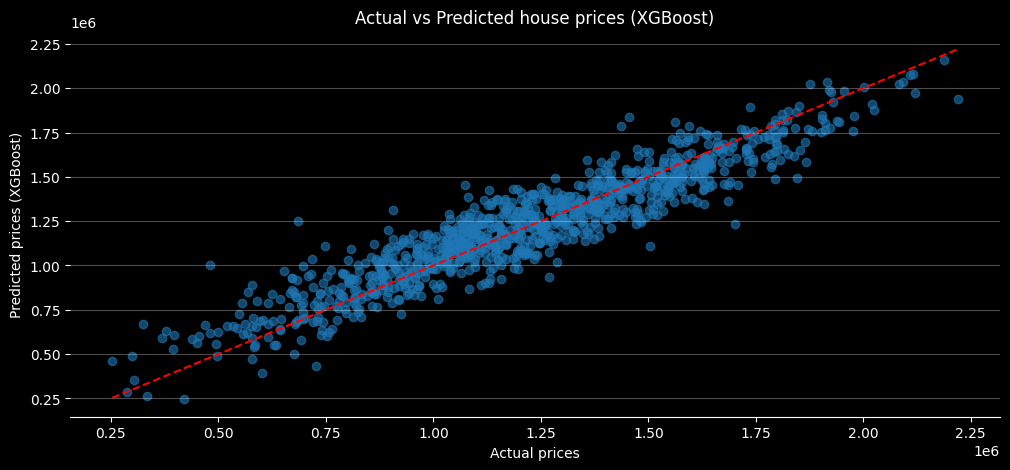

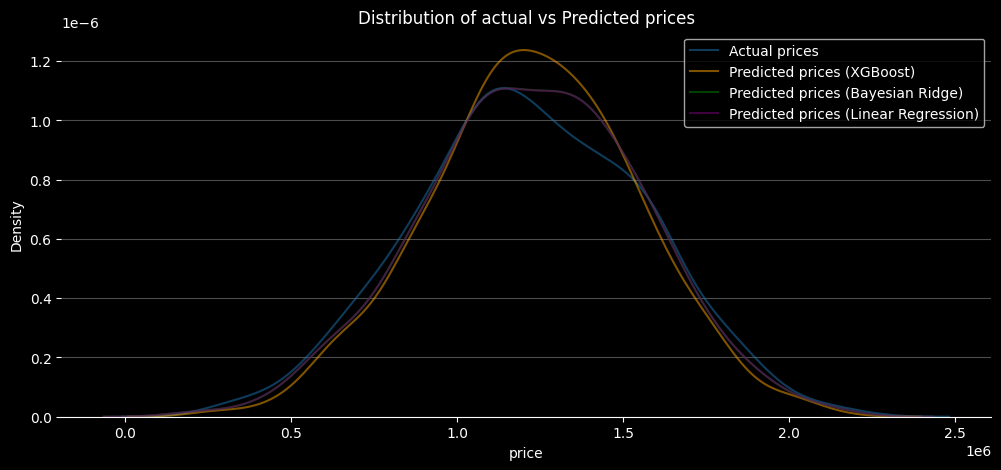

In [265]:
plt.figure(figsize=(12, 5))
plt.scatter(y_eval, y_pred_xgb_eval, color='tab:blue', alpha=0.6)
plt.plot([y_eval.min(), y_eval.max()], [y_eval.min(), y_eval.max()], 'k--', lw=1.5, color='red')
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices (XGBoost)')
plt.title('Actual vs Predicted house prices (XGBoost)')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('eval/actual_vs_predicted_xgb.png', dpi=300)
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Distribution of actual vs Predicted prices')
sns.kdeplot(y_eval, label='Actual prices', color='tab:blue', fill=False, alpha=0.5)
sns.kdeplot(y_pred_xgb_eval, label='Predicted prices (XGBoost)', color='orange', fill=False, alpha=0.5)
sns.kdeplot(y_pred_brr_eval, label='Predicted prices (Bayesian Ridge)', color='green', fill=False, alpha=0.5)
sns.kdeplot(y_pred_lr_eval, label='Predicted prices (Linear Regression)', color='purple', fill=False, alpha=0.5)
plt.xlabel('price')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('eval/predictions_distribution.png', dpi=300)
plt.show()

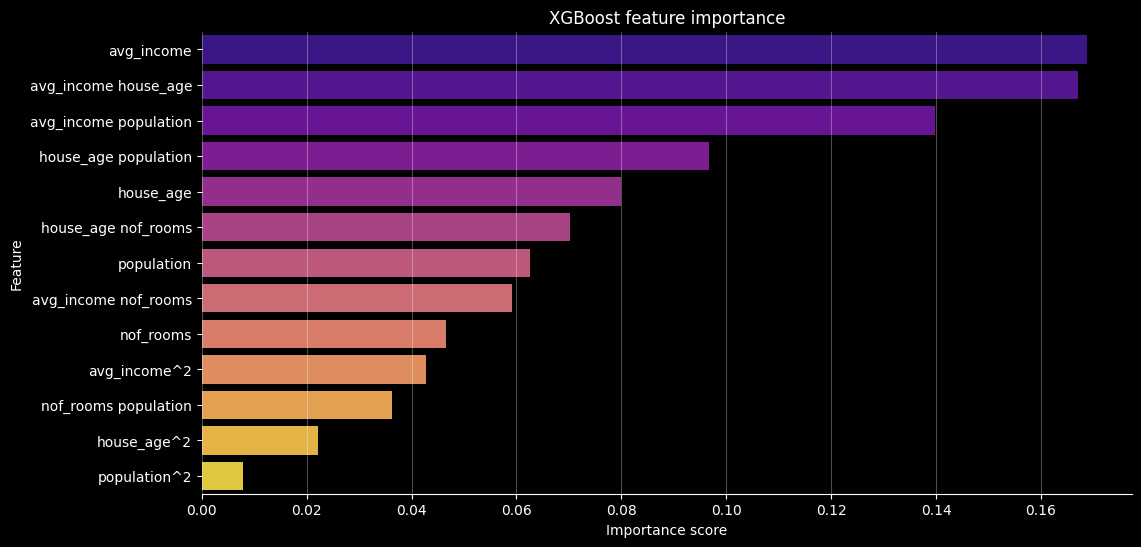

In [268]:
# XGB feature importance
xgb_importance = xgb_model.feature_importances_
features = X_train[selected_by_rf].columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': xgb_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette="plasma", edgecolor='none')
plt.title('XGBoost feature importance')
plt.xlabel('Importance score')
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

## **<span style="color:blue">Conclusion</span>**

In this updated study, several predictive models were tested to estimate housing prices, including Linear Regression, Bayesian Ridge, Random Forest, K-Nearest Neighbors, and XGBoost. Compared to the initial version of this project, the results have improved significantly thanks to a more careful preprocessing pipeline.

A key contribution came from incorporating the **address column**, which had previously been dropped. With proper preprocessing (outlier treatment, encoding, scaling, polynomial features, features selection), this feature provided valuable information and boosted model performance. Among the models tested, **GBoost Regressor achieved the best results**, reaching an $R^2$ of 0.8794 on the validation set, closely followed by Bayesian Ridge and Linear Regression, while KNN and Random Forest remained the least effectives.

These results show that **data preprocessing is as crucial as model selection**. Even a relatively simple feature such as the address, once transformed properly, can provide strong predictive power. Nevertheless, the preprocessing applied here is not yet optimal, and further improvements are possible. For instance, more advanced feature engineering, refined encoding strategies, or external data enrichment (such as geographic or socio-economic indicators linked to addresses) could further enhance performance.

In sum, the project highlights the importance of combining robust models with thoughtful preprocessing. Future work will aim to refine this preprocessing pipeline and test more advanced architectures to push predictive accuracy even further.